In [1]:
%matplotlib

Using matplotlib backend: <object object at 0x1085ca310>


In [2]:
import mne
from pprint import pprint
import json
import csv
import numpy as np
import pandas as pd
from pathlib import Path
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs, corrmap)

In [25]:
root_data_path = Path("/Volumes/Neurolang_1/Project_Assistant/2021_Ongoing/2020_LTTC/Experiment_materials/LTTC_MEG")
meg_data_path = root_data_path / "LTTC_MEG_ALL_results"

print(root_data_path)

sub_id = 17

meg_confile = meg_data_path / Path('de%.3d-1.con' %sub_id) 
meg_raw =  mne.io.read_raw_kit(meg_confile, stim = [193, 194, 195], preload=True) #, slope = '+') #slope=將3個stim_channel的訊號全部加成,讓訊號增強
                                                                #把原始的KIT資料讀進來
#LDT_raw.plot()
#events = mne.find_events(LDT_raw, stim_channel='STI 014') #將集合而成的channel命名為STI 014

#LDT_raw.plot()
n_meg_raw = meg_raw.copy()

n_meg_raw.load_data().pick_types(meg=True, stim=True).filter(0.1, 200, phase='zero-double').resample(100)
print(n_meg_raw.info)
#print(events.shape)

n_meg_raw.plot()

/Volumes/Neurolang_1/Project_Assistant/2021_Ongoing/2020_LTTC/Experiment_materials/LTTC_MEG
Extracting SQD Parameters from /Volumes/Neurolang_1/Project_Assistant/2021_Ongoing/2020_LTTC/Experiment_materials/LTTC_MEG/LTTC_MEG_ALL_results/de017-1.con...
Creating Raw.info structure...


FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/Neurolang_1/Project_Assistant/2021_Ongoing/2020_LTTC/Experiment_materials/LTTC_MEG/LTTC_MEG_ALL_results/de017-1.con'

In [17]:
# ICA
ica_ = ICA(n_components=15, random_state=97)
ica_.fit(n_meg_raw)
#ica_

#Plot ICA
ica_.plot_sources(n_meg_raw)
ica_.plot_components()#sphere = (0.0, 0.02, 0.0, 0.065))  # What is this sphere for??
#ica_.plot_overlay(n_LDT_raw, exclude=[0, 5])  # 5 3 2 1

Fitting ICA to data using 157 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 8.8s.
Creating RawArray with float64 data, n_channels=15, n_times=247500
    Range : 0 ... 247499 =      0.000 ...  2474.990 secs
Ready.
Using pyopengl with version 3.1.6


[<MNEFigure size 1950x1463 with 15 Axes>]

In [20]:
# Checking for every component
for i in range(15):
    #ica_.plot_properties(n_raw, picks=[i])
    ica_.plot_overlay(n_meg_raw, exclude=[i])

Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 157 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 157 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 157 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 157 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 157 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 157 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing o

Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 3 ICA components
    Projecting back using 157 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 2 ICA components
    Projecting back using 157 PCA components


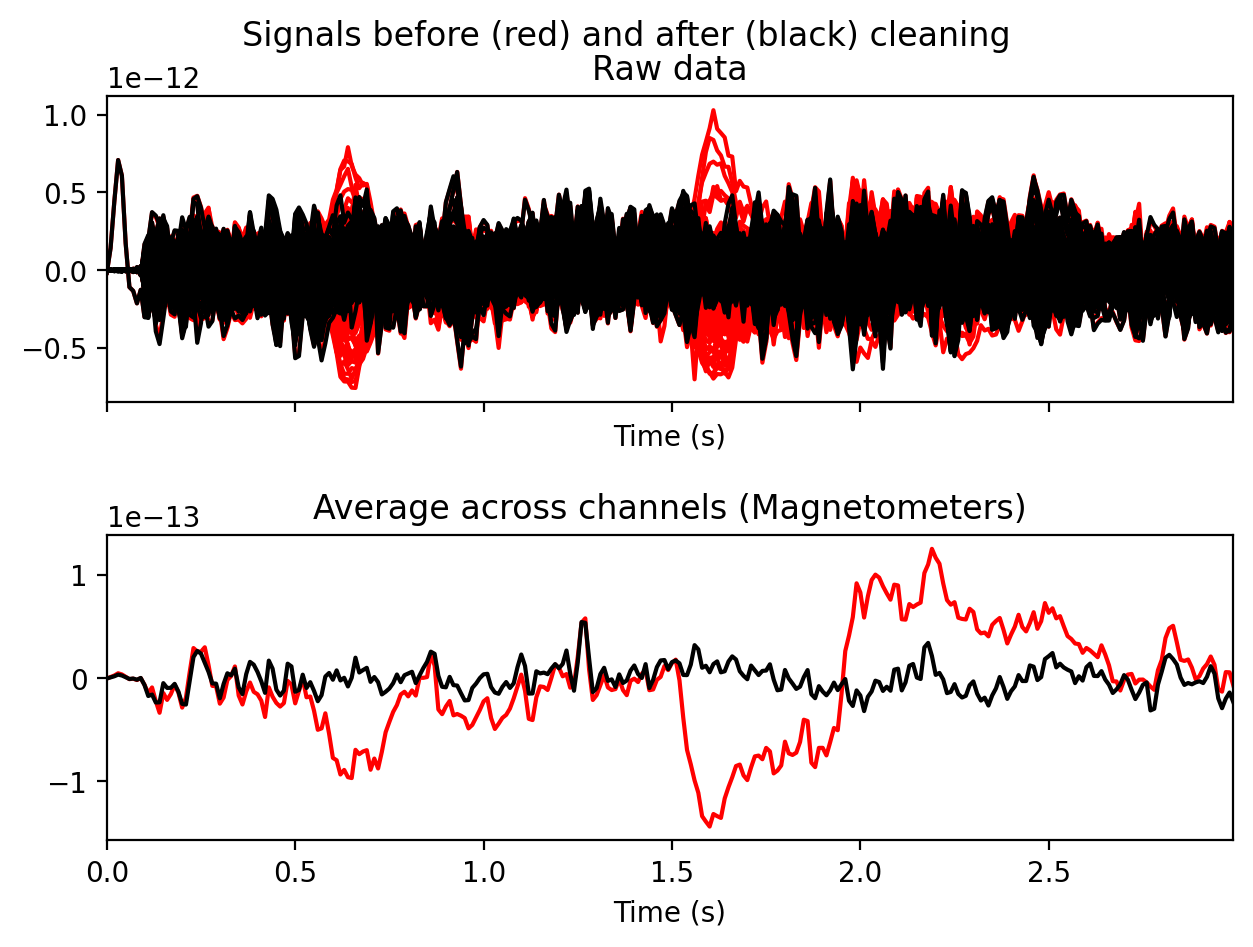

In [21]:
ica_.plot_overlay(n_meg_raw, exclude=[0, 1, 4])

In [22]:
# ICAed epochs
# excluding wanted components
ica_.exclude = [0, 1, 4]
ica_.plot_overlay(n_meg_raw, exclude=ica_.exclude)

n_meg_rawICAed = ica_.apply(n_meg_raw) #changes the Raw object in-place, so let's make a copy first:
#n_LDT_raw.plot()

Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 3 ICA components
    Projecting back using 157 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 3 ICA components
    Projecting back using 157 PCA components


## BELOW IS TO segment the MEG data

In [23]:
# Cut the ICAed MEG according to the stim onset/offset time
eventsArray = mne.find_events(n_meg_rawICAed, stim_channel='STI 014')  #just checking what stim_channel documenting what.

print(eventsArray)
#print(eventsArray[0][1])
print(type(eventsArray))

raw_sfreq = n_meg_rawICAed.info['sfreq']
trigger_tPointsNDArray = eventsArray.copy()
    
if len(trigger_tPointsNDArray)==120:
    # Save the start % end timepoints into ndarray respectively.  
    start_tNDarray = trigger_tPointsNDArray[::4]
    print(start_tNDarray)
    print(len(start_tNDarray))

    end_tNDarray = trigger_tPointsNDArray[1::4]
    print(end_tNDarray)
    print(len(end_tNDarray))
    
    tmpLIST = []
    for points in range(30):
        print(start_tNDarray[points][0]/int(raw_sfreq), end_tNDarray[points][0]/int(raw_sfreq))
        cut_meg = n_meg_rawICAed.copy().crop((start_tNDarray[points][0]/int(raw_sfreq))-0.2, (end_tNDarray[points][0]/int(raw_sfreq))+0.5)
        tmpLIST.append(cut_meg)
    cut_megs_all = mne.concatenate_raws(tmpLIST)
    cut_megs_all.save(meg_data_path / Path('S%.3d_AliceL_cutICAedMEG.fif' %sub_id), overwrite=True)
    
else:
    pass

"""# A perfect cycle of 
[  1119      6      7]
[  7320      5      7]
[  7371      3      7]
[  7552      5      7]
"""
"""
event_id = {'word_onset': 1}  

tmin = -0.1         								# pre stimulis interval (in seconds) #
tmax = 1       								# post stimulus interval #

baseline = (-0.1, 0)  # tmin ~ 0 , -0.1s-0s   
reject = dict(mag=4e-12)  # 5e-12 dropped so many

# Load in the channels layouts
kit_lay = mne.channels.read_layout("KIT-157")

#n_LDT_raw.load_data().pick_types(meg=True, stim=True).filter(0, 30, phase='zero-double').resample(500)
epoch_LDT = mne.Epochs(n_LDT_raw, events, event_id, tmin, tmax, baseline=baseline
                    , reject=reject,preload=True)

#epoch_LDT.plot()
"""

Trigger channel has a non-zero initial value of 7 (consider using initial_event=True to detect this event)
120 events found
Event IDs: [7]
[[  1561      6      7]
 [  8762      5      7]
 [  8813      3      7]
 [  9394      5      7]
 [  9552      6      7]
 [ 16853      5      7]
 [ 16904      3      7]
 [ 17319      5      7]
 [ 17477      6      7]
 [ 24279      5      7]
 [ 24330      3      7]
 [ 24557      5      7]
 [ 24714      6      7]
 [ 31315      5      7]
 [ 31366      3      7]
 [ 31557      5      7]
 [ 31715      6      7]
 [ 38316      5      7]
 [ 38367      3      7]
 [ 38511      5      7]
 [ 50961      6      7]
 [ 57662      5      7]
 [ 57713      3      7]
 [ 57955      5      7]
 [ 58110      6      7]
 [ 64511      5      7]
 [ 64562      3      7]
 [ 64700      5      7]
 [ 64857      6      7]
 [ 71258      5      7]
 [ 71309      3      7]
 [ 71421      5      7]
 [ 71576      6      7]
 [ 77477      5      7]
 [ 77528      3      7]
 [ 77682      5      

/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_32465/1471108232.py:27: RuntimeWarning: This filename (/Volumes/Neurolang_1/Project_Assistant/2021_Ongoing/2020_LTTC/Experiment_materials/LTTC_MEG/LTTC_MEG_ALL_results/S021_AliceL_cutICAedMEG.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  cut_megs_all.save(meg_data_path / Path('S%.3d_AliceL_cutICAedMEG.fif' %sub_id), overwrite=True)


Closing /Volumes/Neurolang_1/Project_Assistant/2021_Ongoing/2020_LTTC/Experiment_materials/LTTC_MEG/LTTC_MEG_ALL_results/S021_AliceL_cutICAedMEG.fif
[done]


'\nevent_id = {\'word_onset\': 1}  \n\ntmin = -0.1         \t\t\t\t\t\t\t\t# pre stimulis interval (in seconds) #\ntmax = 1       \t\t\t\t\t\t\t\t# post stimulus interval #\n\nbaseline = (-0.1, 0)  # tmin ~ 0 , -0.1s-0s   \nreject = dict(mag=4e-12)  # 5e-12 dropped so many\n\n# Load in the channels layouts\nkit_lay = mne.channels.read_layout("KIT-157")\n\n#n_LDT_raw.load_data().pick_types(meg=True, stim=True).filter(0, 30, phase=\'zero-double\').resample(500)\nepoch_LDT = mne.Epochs(n_LDT_raw, events, event_id, tmin, tmax, baseline=baseline\n                    , reject=reject,preload=True)\n\n#epoch_LDT.plot()\n'

In [ ]:
"""
# After the ICAed file, the ESLs data needs to be cut in order to run the TRF productions
# Produce the cut_Q version of the EEG data

#root_data_path = Path('/Users/neuroling/Downloads/碩論data')
#eeg_data_path = root_data_path / "EEG_ESL"

root_data_path = Path('/Volumes/Neurolang_1/Master Program/New_Thesis_topic/Experiments_Results')
eeg_data_path = root_data_path / "EEG_ESLs" / 'Alice_ESL_ICAed_fif'

sub_idLIST = [path.name for path in eeg_data_path.iterdir() if re.match(r'_S\d\d\d', path.name)]  #n_v3
print(sub_idLIST)
print(sub_idLIST[0][0:4])  # >>S001

for sub_idSTR in sub_idLIST:
    subj_data_path = eeg_data_path / Path('%s' %sub_idSTR)

    ICAed_raw = mne.io.read_raw_fif(subj_data_path, preload=True)
    events = mne.events_from_annotations(ICAed_raw)
    print(events)
    raw_sfreq = ICAed_raw.info['sfreq']
    print(raw_sfreq)
    print(type(raw_sfreq))

    events = mne.events_from_annotations(ICAed_raw)
    # covert the time points arrays into a list >> or is it better if we use it as the array??
    trigger_tPointsNDArray = events[0]  #.tolist()
    print(sub_idSTR, len(trigger_tPointsNDArray))
    
    if len(trigger_tPointsNDArray)==48:
        # Save the start % end timepoints into ndarray respectively.  
        start_tNDarray = trigger_tPointsNDArray[::4]
        print(start_tNDarray)
        print(len(start_tNDarray))

        end_tNDarray = trigger_tPointsNDArray[1::4]
        print(end_tNDarray)
        print(len(end_tNDarray))
        
        tmpLIST = []
        for points in range(12):
            print(start_tNDarray[points][0]/int(raw_sfreq), end_tNDarray[points][0]/int(raw_sfreq))
            cut_eeg = ICAed_raw.copy().crop((start_tNDarray[points][0]/int(raw_sfreq))-0.2, (end_tNDarray[points][0]/int(raw_sfreq))+0.5)
            tmpLIST.append(cut_eeg)
        cut_eegs_all = mne.concatenate_raws(tmpLIST)
        cut_eegs_all.save(eeg_data_path/Path('n_2_%s' %sub_idSTR), overwrite=True)
    
        
    else:
        pass
        #print(sub_idSTR, "is ERROR!")
"""